# Connectivity Classifier

Steps:
1. Connectivity pipeline:
    - Parcellation and time-series extraction (using fmriprep data)
    - Aggregate region-level time series into network-level time series (optional)
2. Vectorize connectivity matrices
3. Grid search for optimal parcellation
4. Calculate cross-validated scores
5. Permutation testing
6. Learning curve analysis
7. SHAP analysis


## Inputs
...

## Outputs
...

## Requirements
...

In [28]:
%reload_ext autoreload
%autoreload 3

from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python.acnets.pipeline import ConnectivityVectorizer, ConnectivityPipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import StratifiedShuffleSplit, permutation_test_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import FastICA, PCA
from tqdm import tqdm

from IPython.display import clear_output

from ray.tune.sklearn import TuneSearchCV

from python.acnets.pipeline import ConnectivityPipeline
from python.acnets.plotting.tune_search_plots import plot_scores


In [ ]:
# Parameters

#  WARNING: Ray Tune requires these params to be absolute paths.
BIDS_DIR = Path.home() / 'workspace/acnets/data/julia2018'
PARCELLATION_CACHE_DIR = Path.home() / 'workspace/acnets/data/julia2018_resting'

## Data

- `X`: subject identifiers to be used later on to load connectivity features.
- `y`: labels

In [24]:
subjects = ConnectivityPipeline().transform(None).coords['subject'].values
groups = np.array([s[:4] for s in subjects])  # AVGP or NVGP

X = subjects.reshape(-1, 1)
y = groups

## Pipeline

In [86]:
pipe  = Pipeline([
    ('connectivity', ConnectivityPipeline(agg_networks=True,
                                          bids_dir=BIDS_DIR,
                                          parcellation_cache_dir=PARCELLATION_CACHE_DIR)),
    ('vectorize', ConnectivityVectorizer()),
    ('scale', 'passthrough'),
    ('zerovar', 'passthrough'),
    ('select', 'passthrough'),
    ('reduce', 'passthrough'),
    ('clf', SVC(probability=True))
])

In [87]:
param_space = {
    # 'scale': [StandardScaler(), 'passthrough'],
    # 'select': [SelectFromModel(SVC(kernel='linear')),
    #            SelectFromModel(LinearSVC(C=.1, max_iter=100000)),
    #            'passthrough'],
    # 'reduce': ['passthrough', FastICA(n_components=5, max_iter=1000)],
    # 'zerovar': [VarianceThreshold(threshold=0.0), 'passthrough'],
    # 'clf': [LinearSVC(C=.1, max_iter=100000), RandomForestClassifier(), SVC(kernel='linear', probability=True)],
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': (1e-2, 1e3, 'log-uniform'),
    'clf__kernel': ['linear', 'rbf'],
    'connectivity__atlas': ['dosenbach2010'],
    'connectivity__kind': ['correlation', 'chatterjee'],
    'connectivity__agg_networks': [True],
}

best estimator: Pipeline(steps=[('connectivity',
                 ConnectivityPipeline(bids_dir=PosixPath('/Users/morteza/workspace/acnets/data/julia2018'), kind='chatterjee', parcellation_cache_dir=PosixPath('/Users/morteza/workspace/acnets/data/julia2018_resting'))),
                ('vectorize', ConnectivityVectorizer()),
                ('scale', 'passthrough'), ('zerovar', 'passthrough'),
                ('select', 'passthrough'), ('reduce', 'passthrough'),
                ('clf', SVC(C=3.358508854185137, probability=True))])


<Figure size 432x288 with 0 Axes>

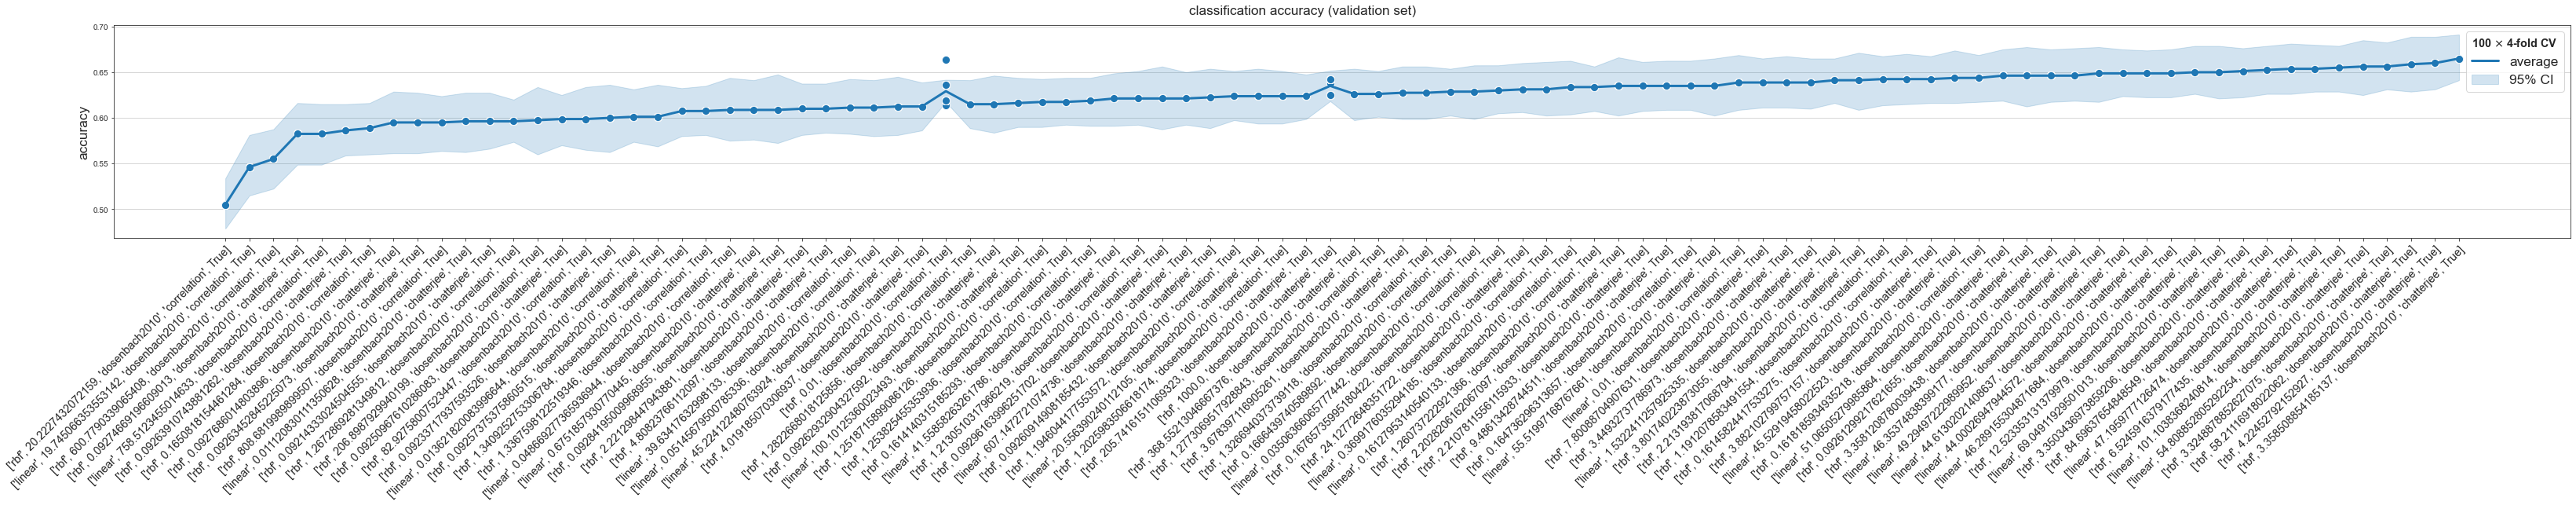

In [88]:
# Parameter Tuning + Model Fitting

cv = StratifiedShuffleSplit(n_splits=100, test_size=0.25)

opt = TuneSearchCV(
    pipe,
    param_space,
    cv=cv,
    n_trials=100,
    # early_stopping=True,
    # max_iters=10,
    search_optimization='bayesian',
    verbose=1,
    scoring='accuracy',
    n_jobs=-1)

# opt = GridSearchCV(pipe, param_grid, verbose=2, cv=cv, scoring='accuracy', n_jobs=-1)

opt.fit(X, y)

clear_output()
print('best estimator:', opt.best_estimator_)

plot_scores(opt)

In [43]:
atlas = opt.best_params_['connectivity__atlas']
connectivity_kind = opt.best_params_['connectivity__kind']
agg_networks = opt.best_params_['connectivity__agg_networks']
feature_name = 'networks' if agg_networks else 'regions'

print('Best hyper-parameters:', atlas, feature_name, connectivity_kind)

Best hyper-parameters: dosenbach2010 networks chatterjee


## Permutation testing

In [40]:
# DEBUG
# grid.best_estimator_.named_steps['select'].estimator_.coef_

# from sklearn.calibration import CalibratedClassifierCV
# model = CalibratedClassifierCV(opt.best_estimator_, cv=cv).fit(X, y)
# scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

obs_score, perm_scores, pvalue = permutation_test_score(
    opt.best_estimator_,
    X, y,
    scoring='roc_auc',
    n_permutations=100,
    n_jobs=-1,
    # cv=cv,
    verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.7s finished


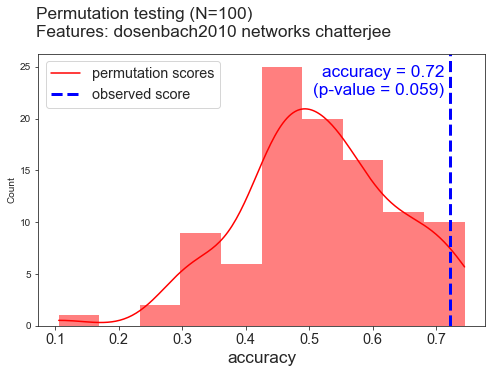

In [44]:
# plot permutation testing results

_, ax = plt.subplots(figsize=(8,5))
g = sns.histplot(perm_scores, kde=True, ax=ax, color='red', lw=0)
ax.axvline(obs_score, ls='--', color='blue', lw=3)
plt.xlabel('accuracy', fontsize='xx-large')
plt.xticks(fontsize='x-large')
ax.text(x=obs_score - .01,
        y=ax.get_ylim()[1] * .85,
        ha='right',
        color='blue',
        s=f'{opt.scoring} = {obs_score:.2f}\n(p-value = {pvalue:.3f})', fontsize='xx-large')

plt.suptitle(f'Permutation testing (N={len(perm_scores)})\n'
             f'Features: {atlas} {feature_name} {connectivity_kind}',
             ha='left',
             x = 0.12,
             y=1.01, fontsize='xx-large')
plt.legend(['permutation scores', 'observed score'], loc='upper left', fontsize='x-large')
plt.show()

## Permutation Importance

In [45]:
from sklearn.inspection import permutation_importance

perm_imp_dataset = ConnectivityPipeline(atlas, connectivity_kind, agg_networks).fit_transform(None)

prep_model = opt.best_estimator[:-1]
clf_model = opt.best_estimator[-1]

subjects = ConnectivityPipeline().transform(None).coords['subject'].values
groups = np.array([s[:4] for s in subjects])

X_perm = subjects
y_perm = groups

X_perm = prep_model.fit_transform(subjects, groups)

importances = []

for train, test in tqdm(cv.split(X_perm,y_perm), total=cv.get_n_splits(X,y)):
    clf_model.fit(X_perm[train], y_perm[train])
    perm_imp_result = permutation_importance(clf_model, X_perm[test], y_perm[test], 
                                            n_repeats=5,
                                            scoring=opt.scoring, n_jobs=-1)
    _importances = perm_imp_result.importances.T
    importances.append(_importances)


perm_imp_scores = pd.DataFrame(np.vstack(importances),
                               columns=prep_model.get_feature_names_out())

100%|██████████| 100/100 [00:01<00:00, 76.51it/s]


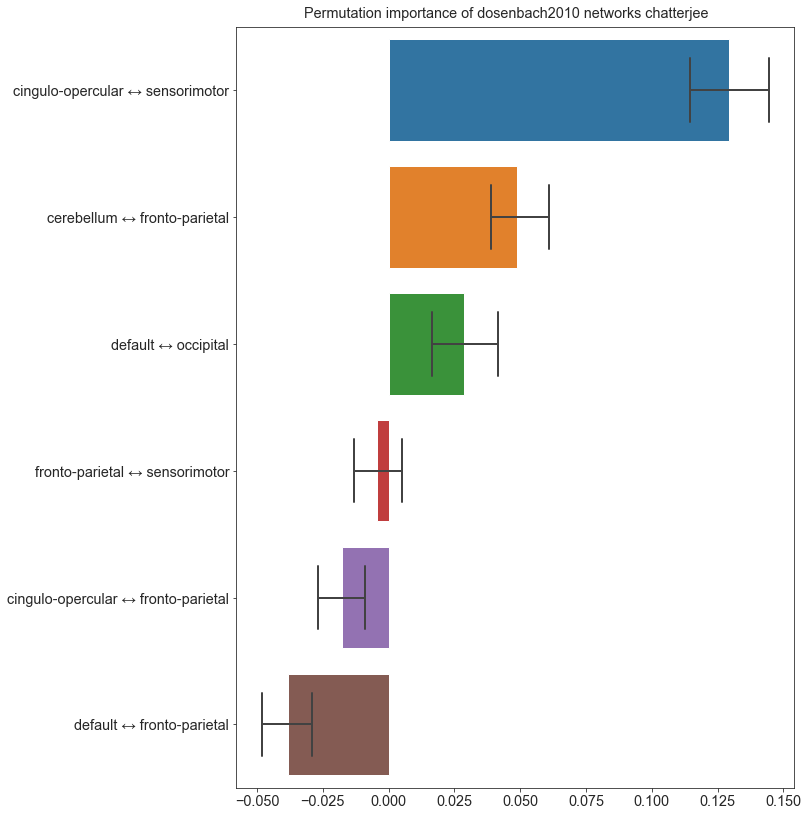

In [46]:
# plot permutation importance scores

# sort by mean importance
sorted_columns = perm_imp_scores.mean(axis=0).sort_values().index
sorted_columns = np.flip(sorted_columns)
perm_imp_scores = perm_imp_scores[sorted_columns]

_, ax = plt.subplots(1,1,figsize=(10,14))
sns.barplot(
    data=perm_imp_scores,
    orient='horizontal',
    capsize=.5,
    errwidth=2,
    ax=ax)

plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.suptitle(f'Permutation importance of {atlas} {feature_name} {connectivity_kind}',
             fontsize='x-large', y=.9)
plt.show()

## SHAP

In [64]:

# SHAP
import shap

shap_values_cv = []
X_test_indices_cv = []
y_test_cv = []
y_pred_cv = []
expected_value_cv = []

from sklearn.model_selection import RepeatedStratifiedKFold
shap_cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2)

subjects = ConnectivityPipeline().transform(None).coords['subject'].values

groups = np.array([s[:4] for s in subjects])

X = subjects.reshape(-1, 1)
y = groups

aggregated=True
feature_name = 'networks' if aggregated else 'regions'

from sklearn.preprocessing import LabelEncoder
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)


prep_model = opt.best_estimator[:-1]
clf_model = opt.best_estimator[-1]

for train, test in tqdm(shap_cv.split(X, y), total=shap_cv.get_n_splits(X, y)):

    # train the model
    X_train_vec = prep_model.fit_transform(X[train], y[train])
    model = clf_model.fit(X_train_vec, y[train])

    X_test_vec = prep_model.transform(X[test])
    y_pred = model.predict(X_test_vec)

    X_test_indices_cv.append(test)
    y_test_cv.append(y[test])
    y_pred_cv.append(y_pred)

    explainer = shap.Explainer(
        model.predict, X_train_vec,
        feature_names=prep_model.get_feature_names_out(),
        # algorithm='tree',
        # approximate=True,
        # model_output='raw',
        # feature_perturbation='tree_path_dependent',
        # feature_perturbation='interventional',
    )

    shap_values = explainer(X_test_vec)#, check_additivity=True)

    shap_values_cv.append(shap_values)


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


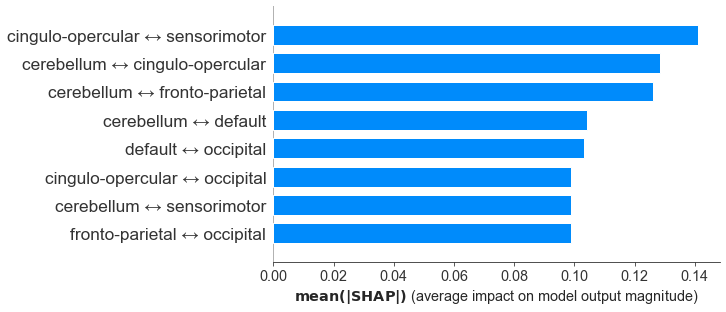

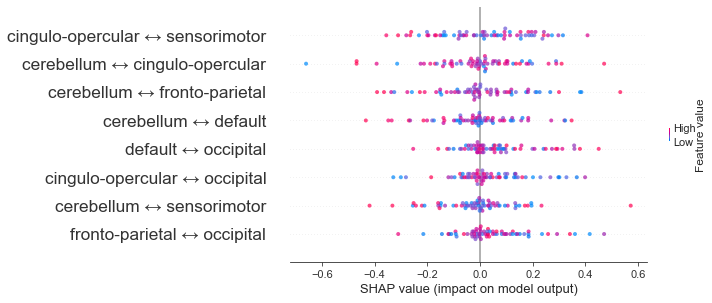

In [79]:
# merge CV SHAPs

X = subjects.reshape(-1, 1)
X_test = pd.DataFrame(X[np.hstack(X_test_indices_cv)], columns=['subject'])
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=shap_values_cv[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)

shap.summary_plot(shap_values, max_display=21, show=False, plot_type='bar')
plt.yticks(fontsize='xx-large')
plt.xticks(fontsize='x-large')
plt.xlabel('$\\bf{mean(|SHAP|)}$ (average impact on model output magnitude)',fontsize='x-large')
# plt.suptitle('SHAP summary plot for {} {} ({})'.format(atlas, connectivity, feature_name), fontsize='xx-large', y=.92)
plt.show()
shap.plots.beeswarm(deepcopy(shap_values), max_display=16, alpha=.7, show=False)
plt.yticks(fontsize='xx-large')

plt.show()

In [80]:
# shap.force_plot(.5, shap_values[0])
shap.initjs()
shap.plots.force(.5, shap_values.values[0], feature_names=prep_model.get_feature_names_out())

In [85]:
if atlas == 'dosenbach2010':
    n_nodes = 6
elif atlas == 'gordon2014_2mm':
    n_nodes = 13
elif atlas == 'seitzman2018':
    n_nodes = 14

print(atlas, connectivity_kind)

shap_values_2d = np.zeros((n_nodes, n_nodes))
shap_values_2d_triu_indices = np.triu_indices(n_nodes, k=0)
shap_values_2d[shap_values_2d_triu_indices] = np.abs(shap_values.values).mean(0)
shap_values_2d = shap_values_2d + shap_values_2d.T - np.diag(np.diag(shap_values_2d))

# adj_df = pd.DataFrame(shap_values_2d)
feature_names_2d = get_feature_labels(atlas, connectivity, aggregated)
shap_2d = pd.DataFrame(shap_values_2d,
                       columns=feature_names_2d.columns,
                       index=feature_names_2d.index)

# sns.heatmap(shap_2d)
# plt.show()

import networkx as nx
G = nx.from_pandas_adjacency(shap_2d)

pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
label_options = {'ec': 'k', 'fc': 'white', 'alpha': 0.7}
nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)


# edges
_thr = 0.04
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > _thr]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= _thr]

edge_labels = nx.get_edge_attributes(G, 'weight')
# edge_weights = [int(i*100) for in in edge_labels]
edge_weights = [int(d['weight']*100) for (u, v, d) in G.edges(data=True) if d['weight'] >= _thr]
print(edge_weights)
nx.draw_networkx_edges(G, pos,
                       edgelist=elarge,
                       alpha=.5,
                       edge_color="b",
                       width=edge_weights)
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=0.2, edge_color='black', style='dashed')
# # nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)

# plot the graph
plt.rcParams["figure.figsize"] = (8,6)
plt.gca().margins(.2, 0.05)
plt.tight_layout()
plt.axis("off")
plt.show()

dosenbach2010 chatterjee


ValueError: shape mismatch: value array of shape (66,) could not be broadcast to indexing result of shape (21,)

In [ ]:
n_samples = 100
select_mask = np.where(y_pred == y_test)[0]     # correctly classified
# select_mask = np.where(y_pred != y_test)[0]   # misclassified
# select_mask = np.where(y_pred)[0]             # predicted class
# select_mask = np.where(y_test)[0]             # true class

select_mask = shap.utils.sample(select_mask, n_samples, random_state=None)

print((y_pred == y_test).mean(), select_mask)  # TODO show subject labels
highlight_mask = (y_test[select_mask] == 1)

def legend_labels(idx):
  return [y_encoder.classes_[i] for i in idx.astype(int)]

shap.plots.decision(.5, #np.mean(expected_value_cv),
                    shap_values.values[select_mask],
                    link='logit',
                    # feature_order='hclust',
                    # highlight=misclassified,
                    # ignore_warnings=True,
                    legend_labels=legend_labels(highlight_mask)[:1],
                    highlight=highlight_mask,
                    show=False,
                    feature_display_range=slice(-1, -16, -1),
                    feature_names = feature_names.tolist())

plt.yticks(fontsize='xx-large')

# plt.suptitle(f'SHAP decision paths for {n_samples} correctly classified samples.\n'
#              'Solid lines are AVGPs, and dotted lines are NVGPs.\n'
#              'Connectivities are ordered by their SHAP importance in the sample.',
#              ha='left', x=-.3, fontsize=14)
plt.show()